## Introduction

__Loan Approval System__

The goal of this project is to showcase machine learning methods for developing a loan approval system. The first part of this notebook starts by preprocessing data and then performing feature engineering for the classification models. Next, we will be creating two classification models (logistic regression and random forest classifier) that will predict whether customers are 'good' or 'bad' borrowers. Before creating our time-to-default model, we will be running a special type of EDA called vintage analysis on the data that will show the distribution of bad borrowers in our loan portfolio by their origination date. The next set of models include our time-to-default model that will allow us to understand when exactly borrowers are turning bad segmented by our features. The plan is then to assess the feature importance of the different models using random forest built-in functions and WoE, IV metrics. At this point, the goal of creating a risk rating scorcard for developing a loan approval system is complete and a example of implementing such system will be shown.


## Loading data

In [2]:
import kagglehub
import pandas as pd
import numpy as np

# This requires kagglehub
path = kagglehub.dataset_download("rikdifos/credit-card-approval-prediction")

# path that kagglehub automatically creates where datasets are held
app_fp = path + "/application_record.csv"
credit_fp = path + "/credit_record.csv"

# Load training data into two dataframes
# app_df: contains borrower information (features)
# credit_df: contains loan balance by date (broken down by borrower id)
app_df = pd.read_csv(app_fp)
credit_df = pd.read_csv(credit_fp)

print(app_df.shape)
print(credit_df.shape)


(438557, 18)
(1048575, 3)


## Cleaning data & Feature Engineering

### Pre-processing data

In [4]:
# Definition of Status in credit_df
# 0: 1-29 days past due 
# 1: 30-59 days past due 
# 2: 60-89 days overdue 
# 3: 90-119 days overdue 
# 4: 120-149 days overdue 
# 5: Overdue or bad debts, write-offs for more than 150 days 
# C: paid off that month
# X: No loan for the month

# Starting by creating df showing min and max months that 
# shows when the customer opened, closed months and loan window

# calculate the earliest and latest months balance for each customer
open_end_mos = credit_df.copy()
open_end_mos = open_end_mos[['ID', 'MONTHS_BALANCE']].groupby('ID').agg(
    open_month=('MONTHS_BALANCE', 'min'),
    end_month=('MONTHS_BALANCE', 'max')
)

# calculate the observation window for each customer
open_end_mos['window'] = open_end_mos['end_month'] - open_end_mos['open_month']

# creating main table
credit0 = credit_df.copy()
# bringing in open and end month of loan
credit0 = credit0.merge(open_end_mos, on='ID', how='left')
# creating indicator to track when loan turned bad
credit0['bad_ind'] = np.where(credit0['STATUS'].isin(['2', '3', '4', '5']), 1, 0)
# tracks when loan was originated and decreases ans loan comes to maturity
# essentially positive value of MONTHS_BALANCE in descending order
credit0['month_on_book'] = credit0['MONTHS_BALANCE'] - credit0['open_month']

print(credit0.shape)
credit0.head()

(1048575, 8)


,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,bad_ind,month_on_book
0,5001711,0,X,-3,0,3,0,3
1,5001711,-1,0,-3,0,3,0,2
2,5001711,-2,0,-3,0,3,0,1
3,5001711,-3,0,-3,0,3,0,0
4,5001712,0,C,-18,0,18,0,18


In [10]:
# creating table that shows when borrowers became "bad"
# allows us to look at a one loan per customer view
bad_borrowers = credit0.copy()
bad_borrowers = credit0[credit0['bad_ind'] == 1].reset_index(drop=True)

# creating a temp column called row_number that counts number of records
# by ID and month_on_book order
bad_borrowers['row_number'] = (
    bad_borrowers
    .sort_values(['ID', 'month_on_book'], ascending=[True, False])  
    .groupby('ID')
    .cumcount() + 1
)

# selecting first instance of when the borrower turned bad based on temp column
bad_borrowers_final = bad_borrowers.copy()
bad_borrowers_final = bad_borrowers_final[bad_borrowers_final['row_number']==1].reset_index(drop=True)
bad_borrowers_final.drop('row_number', axis=1, inplace=True)

print(bad_borrowers_final.shape)
bad_borrowers_final.head()

(667, 8)


,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,bad_ind,month_on_book
0,5002126,-46,2,-55,0,55,1,9
1,5002255,-4,2,-37,0,37,1,33
2,5002283,-48,2,-60,0,60,1,12
3,5002303,-9,2,-21,0,21,1,12
4,5002380,-5,2,-56,0,56,1,51


In [ ]:
bb_list = bad_borrowers['ID'].unique()

# creating table that shows when good borrowers
# allows us to look at a one loan per customer view
good_borrowers = credit0.copy()
good_borrowers = good_borrowers[~good_borrowers["ID"].isin(bb_list)].reset_index(drop=True)

good_borrowers['row_number'] = (
    good_borrowers
    .sort_values(['ID', 'month_on_book'], ascending=[True, False])  
    .groupby('ID')
    .cumcount() + 1
)

# selecting first instance good borrower with the max number of month_on_book
# to show when loan matured
good_borrowers_final = good_borrowers.copy()
good_borrowers_final = good_borrowers_final[good_borrowers_final['row_number']==1].reset_index(drop=True)
good_borrowers_final.drop('row_number', axis=1, inplace=True)

print(good_borrowers_final.shape)
good_borrowers_final.head()

(45318, 8)


,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,bad_ind,month_on_book
0,5001711,0,X,-3,0,3,0,3
1,5001712,0,C,-18,0,18,0,18
2,5001713,0,X,-21,0,21,0,21
3,5001714,0,X,-14,0,14,0,14
4,5001715,0,X,-59,0,59,0,59


In [20]:
## cleaning up both tables and concatenating 
good_borrowers_cln = good_borrowers_final[['ID', 'MONTHS_BALANCE', 'open_month', 
                                  'end_month', 'month_on_book', 'bad_ind']]
bad_borrowers_cln = bad_borrowers_final[['ID', 'MONTHS_BALANCE', 'open_month', 
                                  'end_month', 'month_on_book', 'bad_ind']]

all_loans = pd.concat([bad_borrowers_cln, good_borrowers_cln])

print(all_loans.shape)
all_loans.head()

(45985, 6)


,ID,MONTHS_BALANCE,open_month,end_month,month_on_book,bad_ind
0,5002126,-46,-55,0,9,1
1,5002255,-4,-37,0,33,1
2,5002283,-48,-60,0,12,1
3,5002303,-9,-21,0,12,1
4,5002380,-5,-56,0,51,1


In [22]:
## Joining on the customer table to start building features

cust_loans = all_loans.join(
    app_df,
    on="ID", 
    how="left"
    )

print(f"df length: {cust_loans.count()}")
cust_loans.show(5)

df length: 45985


+-------+--------------+----------+---------+-------------+-----------+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|MONTHS_BALANCE|open_month|end_month|month_on_book|overdue_ind|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+--------------+----------+---------+-------------+-----------+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5001712|             0|       

In [23]:
## only want data with feature data

all_data = cust_loans.dropna()

print(f"df length: {all_data.count()}")
all_data.show()

df length: 25134


+-------+--------------+----------+---------+-------------+-----------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|MONTHS_BALANCE|open_month|end_month|month_on_book|overdue_ind|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+--------------+----------+---------+-------------+-----------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5008806| 

### Feature engineering -- Encoding, creating new features

In [24]:
## renaming columns

new_column_names = {"MONTHS_BALANCE": "months_balance", 
                    "CODE_GENDER": "gender",
                    "FLAG_OWN_CAR": "owns_car",
                    "FLAG_OWN_REALTY": "owns_home",
                    "CNT_CHILDREN": "children_cnt",
                    "AMT_INCOME_TOTAL": "income",
                    "NAME_INCOME_TYPE": "income_source",
                    "NAME_EDUCATION_TYPE": "education_type",
                    "NAME_FAMILY_STATUS": "marital_status",
                    "DAYS_BIRTH": "days_from_birth",
                    "DAYS_EMPLOYED": "days_employed",
                    "FLAG_MOBIL": "mobile_phone",
                    "FLAG_WORK_PHONE": "work_phone",
                    "FLAG_PHONE": "home_phone",
                    "FLAG_EMAIL": "email",
                    "NAME_HOUSING_TYPE": "housing",
                    "OCCUPATION_TYPE": "occupation_type",
                    "CNT_FAM_MEMBERS": "family_size"
                    }

for old_name, new_name in new_column_names.items():
    all_data = all_data.withColumnRenamed(old_name, new_name)

all_data.show()

+-------+--------------+----------+---------+-------------+-----------+------+--------+---------+------------+--------+--------------------+--------------------+--------------------+-----------------+---------------+-------------+------------+----------+----------+-----+---------------+-----------+
|     ID|months_balance|open_month|end_month|month_on_book|overdue_ind|gender|owns_car|owns_home|children_cnt|  income|       income_source|      education_type|      marital_status|          housing|days_from_birth|days_employed|mobile_phone|work_phone|home_phone|email|occupation_type|family_size|
+-------+--------------+----------+---------+-------------+-----------+------+--------+---------+------------+--------+--------------------+--------------------+--------------------+-----------------+---------------+-------------+------------+----------+----------+-----+---------------+-----------+
|5008806|             0|       -29|        0|           29|          0|     M|       Y|        Y|   

In [25]:
from pyspark.sql.functions import round

## creating age, years_employed, and loan term features
## due to the structure of the data, this extra step is needed
all_data = all_data.withColumn("age", round((col("days_from_birth") * -1) / 365))\
                    .withColumn("years_employed", round(((col("days_employed") * -1) / 365), 2))\
                    .withColumn("loan_term", (col("open_month") * -1))

all_data.show()

+-------+--------------+----------+---------+-------------+-----------+------+--------+---------+------------+--------+--------------------+--------------------+--------------------+-----------------+---------------+-------------+------------+----------+----------+-----+---------------+-----------+----+--------------+---------+
|     ID|months_balance|open_month|end_month|month_on_book|overdue_ind|gender|owns_car|owns_home|children_cnt|  income|       income_source|      education_type|      marital_status|          housing|days_from_birth|days_employed|mobile_phone|work_phone|home_phone|email|occupation_type|family_size| age|years_employed|loan_term|
+-------+--------------+----------+---------+-------------+-----------+------+--------+---------+------------+--------+--------------------+--------------------+--------------------+-----------------+---------------+-------------+------------+----------+----------+-----+---------------+-----------+----+--------------+---------+
|5008806| 

In [26]:
## showing categorical values
## Allows us to see how we need to encode the data
print(all_data.select("income_source").distinct().show())
print(all_data.select("education_type").distinct().show())
print(all_data.select("marital_status").distinct().show())
print(all_data.select("housing").distinct().show())
print(all_data.select("occupation_type").distinct().show(20))


+--------------------+
|       income_source|
+--------------------+
|             Student|
|Commercial associate|
|       State servant|
|             Working|
|           Pensioner|
+--------------------+

None


+--------------------+
|      education_type|
+--------------------+
|   Incomplete higher|
|Secondary / secon...|
|     Lower secondary|
|    Higher education|
|     Academic degree|
+--------------------+

None


+--------------------+
|      marital_status|
+--------------------+
|           Separated|
|             Married|
|Single / not married|
|               Widow|
|      Civil marriage|
+--------------------+

None


+-------------------+
|            housing|
+-------------------+
|  House / apartment|
|Municipal apartment|
|    Co-op apartment|
|   Rented apartment|
|   Office apartment|
|       With parents|
+-------------------+

None


+--------------------+
|     occupation_type|
+--------------------+
|            Managers|
|            HR staff|
|      Medicine staff|
|         Accountants|
|            Laborers|
|      Cleaning staff|
|Private service s...|
|             Drivers|
|         Sales staff|
|       Realty agents|
|            IT staff|
|      Security staff|
|         Secretaries|
|  Low-skill Laborers|
|          Core staff|
|       Cooking staff|
|High skill tech s...|
|Waiters/barmen staff|
+--------------------+

None


In [27]:
## encoding binary and categorical variables

features_transformed = all_data.withColumn(
    "gender", 
    F.when(all_data["gender"] == "M", 1).otherwise(0)
).withColumn(
    "owns_car", 
    F.when(all_data["owns_car"] == "Y", 1).otherwise(0)
).withColumn(
    "owns_home", 
    F.when(all_data["owns_home"] == "Y", 1).otherwise(0)
).withColumn(
    "working", 
    F.when(all_data["income_source"].isin(['Commercial associate', 
                                           'State servant', 'Working']), 1).otherwise(0)
).withColumn(
    "education_completed", 
    F.when(all_data["education_type"].isin(['Secondary / secondary special', 'Incomplete higher']), 'high_school')\
        .when(all_data["education_type"].isin(['Higher education', 'Academic degree']), 'higher_education')\
        .otherwise('no_high_school')
).withColumn(
    "married", 
    F.when(all_data["marital_status"].isin(['Married', 'Civil marriage']), 1).otherwise(0)
).withColumn(
    "occupation_group", 
    F.when(all_data["occupation_type"].isin(['Sales staff',
                                             'Secretaries', 'HR staff', 'Realty agents',
                                             'Medicine staff']), "office_work")
    .when(all_data["occupation_type"].isin(['Security staff', 'Drivers', 'Laborers',
                                            'Cleaning staff', 'Core staff', 'Cooking staff',
                                            'Low-skill Laborers', 'Waiters/barmen staff',
                                            'Private service staff']), "labor_work")
    .when(all_data["occupation_type"].isin(['High skill tech staff', 'IT staff', 
                                            'Managers', 'Accountants', ]), "skill_work")
    .otherwise(0)
)

print(f"df length: {features_transformed.count()}")
features_transformed.show()

df length: 25134


+-------+--------------+----------+---------+-------------+-----------+------+--------+---------+------------+--------+--------------------+--------------------+--------------------+-----------------+---------------+-------------+------------+----------+----------+-----+---------------+-----------+----+--------------+---------+-------+-------------------+-------+----------------+
|     ID|months_balance|open_month|end_month|month_on_book|overdue_ind|gender|owns_car|owns_home|children_cnt|  income|       income_source|      education_type|      marital_status|          housing|days_from_birth|days_employed|mobile_phone|work_phone|home_phone|email|occupation_type|family_size| age|years_employed|loan_term|working|education_completed|married|occupation_group|
+-------+--------------+----------+---------+-------------+-----------+------+--------+---------+------------+--------+--------------------+--------------------+--------------------+-----------------+---------------+-------------+----

In [28]:
## only including features we want to test
## only leaving out features that are redudant
final_data = features_transformed.select("overdue_ind", "gender", "owns_car", "owns_home",
                                         "children_cnt", "income", "age", "years_employed",
                                         "loan_term", "working", "education_completed", 
                                         "married", "occupation_group")

print(f"df length: {final_data.count()}")
final_data.show(5)

df length: 25134


+-----------+------+--------+---------+------------+--------+----+--------------+---------+-------+-------------------+-------+----------------+
|overdue_ind|gender|owns_car|owns_home|children_cnt|  income| age|years_employed|loan_term|working|education_completed|married|occupation_group|
+-----------+------+--------+---------+------------+--------+----+--------------+---------+-------+-------------------+-------+----------------+
|          0|     1|       1|        1|           0|112500.0|59.0|          3.11|       29|      1|        high_school|      1|      labor_work|
|          0|     1|       0|        1|           1|405000.0|32.0|          5.52|       39|      1|   higher_education|      1|      skill_work|
|          0|     1|       0|        1|           1|405000.0|32.0|          5.52|        4|      1|   higher_education|      1|      skill_work|
|          0|     1|       1|        1|           0|112500.0|56.0|         12.19|       43|      1|        high_school|      1|   

In [29]:
## encoding our categorical values -- education and occupation type
final_data_df = final_data.toPandas()
encode_df = pd.get_dummies(final_data_df, columns=["education_completed"])
encode_df = pd.get_dummies(encode_df, columns=["occupation_group"])
encode_df[encode_df.select_dtypes('bool').columns] = encode_df.select_dtypes('bool').astype(int)

## changing target variable name to something meaningful
encode_df = encode_df.rename(columns={'overdue_ind': 'bad_borrower_ind'})

print(encode_df.shape)
encode_df.head()

(25134, 17)


,bad_borrower_ind,gender,owns_car,owns_home,children_cnt,income,age,years_employed,loan_term,working,married,education_completed_high_school,education_completed_higher_education,education_completed_no_high_school,occupation_group_labor_work,occupation_group_office_work,occupation_group_skill_work
0,0,1,1,1,0,112500.0,59.0,3.11,29,1,1,1,0,0,1,0,0
1,0,1,0,1,1,405000.0,32.0,5.52,39,1,1,0,1,0,0,0,1
2,0,1,0,1,1,405000.0,32.0,5.52,4,1,1,0,1,0,0,0,1
3,0,1,1,1,0,112500.0,56.0,12.19,43,1,1,1,0,0,1,0,0
4,0,1,1,1,0,112500.0,56.0,12.19,11,1,1,1,0,0,1,0,0


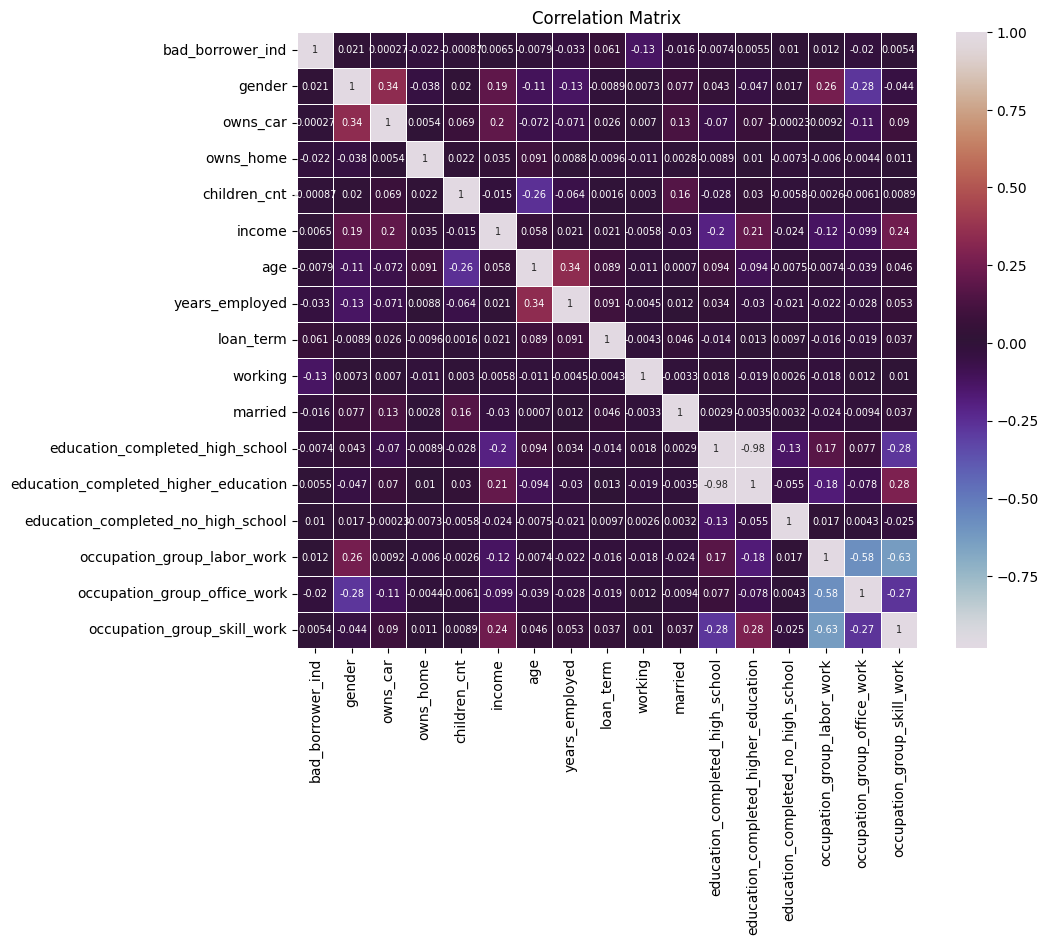

In [30]:
## correlation matrix relative to bad_borrower_ind
## this also shows the imbalance of our data
import seaborn as sns

corr_matrix = encode_df.corr(numeric_only=True) #correlation
plt.figure(figsize=(10, 8))  #heatmap
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 7}, cmap='twilight', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## ML Models

### Handling Imbalanced data with SMOTE

In [31]:
## an imbalance in the data is present
## as expected, we see that the majority of customers in our portfolio are good customers
encode_df['bad_borrower_ind'].value_counts(normalize=True)

bad_borrower_ind
0    0.98321
1    0.01679
Name: proportion, dtype: float64

In [32]:
## handling imbalance in data using Synthetic Minority Oversampling Technique
## This technique is common in the industry

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Separate Features and Target
features = encode_df.drop('bad_borrower_ind', axis=1)  #Features
target = encode_df['bad_borrower_ind']              #Target

#Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)

#Generate a balanced dataset using SMOTE
features_resampled, target_resampled = smote.fit_resample(features, target)

#Confirm the new class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(target_resampled).value_counts())

Class distribution after SMOTE:
bad_borrower_ind
0    24712
1    24712
Name: count, dtype: int64


In [33]:
#Split the resampled data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(
    features_resampled, target_resampled, test_size=0.2, random_state=42, stratify=target_resampled
)

#Normalize features using StandardScaler
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

### Logistic Regression

In [55]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# initializing kfold with parameters
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Train a logistic regression model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(features_train_scaled, target_train)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(model, features_train_scaled, target_train, cv=kfold, scoring='accuracy')

# Print the cross-validation results; suspected overfitting but scores show consistency
print(f"Cross-validation accuracy scores: {cv_scores_lr}")
print(f"Mean accuracy: {cv_scores_lr.mean():.4f}")
print(f"Standard deviation: {cv_scores_lr.std():.4f}")

print("------------")

#Make predictions and evaluate the model
target_pred = model.predict(features_test_scaled)

#Print metrics
print("Logistic Regression Performance:")
print(classification_report(target_test, target_pred))

#Calculate and display AUC-ROC score
auc_roc = roc_auc_score(target_test, model.predict_proba(features_test_scaled)[:, 1])
print("AUC-ROC:", auc_roc)

accuracy = model.score(features_test_scaled, target_test)
print(f'Accuracy Score: {accuracy:.2f}')

Cross-validation accuracy scores: [0.84711684 0.84433485 0.85546282 0.85065756 0.84127988]
Mean accuracy: 0.8478
Standard deviation: 0.0049
------------
Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      4943
           1       0.90      0.77      0.83      4942

    accuracy                           0.84      9885
   macro avg       0.85      0.84      0.84      9885
weighted avg       0.85      0.84      0.84      9885

AUC-ROC: 0.9220230211624172
Accuracy Score: 0.84


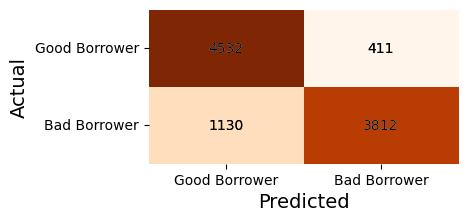

In [56]:
## confusion matrix -- allows us to see how many Bad Borrowers our model predicted correctly
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(target_test, target_pred)
labels = ['Good Borrower', 'Bad Borrower']

cm_df = pd.DataFrame(cm, index=labels, columns=labels)

## plotting the dataframe for better visualizaiton and interpretation
plt.figure(figsize=(4, 2))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

## Had to use below code because labels were being left off
for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm_df.iat[i, j]}',
                 ha='center', va='center', color='black', fontsize=10)

plt.show()

AUC Score: 0.84


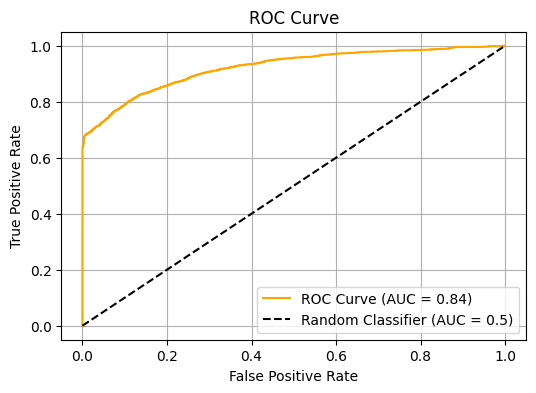

In [57]:
# AUC Score and ROC Curve

from sklearn.metrics import roc_auc_score, roc_curve
auc_score = roc_auc_score(target_test, target_pred)
print(f"AUC Score: {auc_score:.2f}")

fpr, tpr, thresholds = roc_curve(target_test, model.predict_proba(features_test_scaled)[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="orange")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Train a Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(features_train_scaled, target_train)

#Make predictions
target_pred_rf = rf_model.predict(features_test_scaled)

# Perform k-fold cross-validation
cv_scores_rf = cross_val_score(rf_model, features_train_scaled, target_train, cv=kfold, scoring='accuracy')

# Print the cross-validation results; suspected overfitting but scores show consistency
print(f"Cross-validation accuracy scores: {cv_scores_rf}")
print(f"Mean accuracy: {cv_scores_rf.mean():.4f}")
print(f"Standard deviation: {cv_scores_rf.std():.4f}")

print("------------")
#Print performance metrics
print("Random Forest Performance:")
print(classification_report(target_test, target_pred_rf))
print("AUC-ROC:", roc_auc_score(target_test, rf_model.predict_proba(features_test_scaled)[:, 1]))

Cross-validation accuracy scores: [0.98937785 0.99076884 0.98899848 0.98836621 0.98735298]
Mean accuracy: 0.9890
Standard deviation: 0.0011
------------
Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4943
           1       0.99      0.99      0.99      4942

    accuracy                           0.99      9885
   macro avg       0.99      0.99      0.99      9885
weighted avg       0.99      0.99      0.99      9885

AUC-ROC: 0.9981974394786114


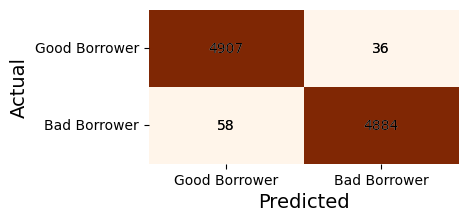

In [53]:
## confusion matrix -- Random Forest Model

from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(target_test, target_pred_rf)
labels = ['Good Borrower', 'Bad Borrower']

cm_df_rf = pd.DataFrame(cm_rf, index=labels, columns=labels)

## plotting the dataframe for better visualizaiton and interpretation
plt.figure(figsize=(4, 2))
sns.heatmap(cm_df_rf, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

## Had to use below code because labels were being left off
for i in range(cm_df_rf.shape[0]):
    for j in range(cm_df_rf.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm_df_rf.iat[i, j]}',
                 ha='center', va='center', color='black', fontsize=10)

plt.show()

AUC Score: 0.99


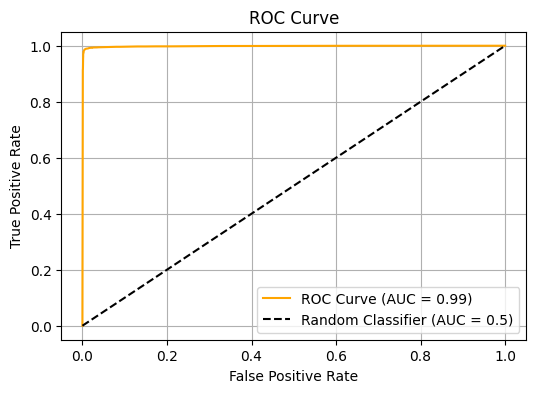

In [54]:
auc_score = roc_auc_score(target_test, target_pred_rf)
print(f"AUC Score: {auc_score:.2f}")

fpr, tpr, thresholds = roc_curve(target_test, rf_model.predict_proba(features_test_scaled)[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="orange")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### xgBoost

In [58]:
from xgboost import XGBClassifier

#Adjust class weights for imbalance
xgb_model = XGBClassifier(scale_pos_weight=len(target_train[target_train == 0]) / len(target_train[target_train == 1]),
                           random_state=42)

#Train the model
xgb_model.fit(features_train_scaled, target_train)

#Make predictions and evaluate
target_pred_xgb = xgb_model.predict(features_test_scaled)

# Perform k-fold cross-validation
cv_scores_xgb = cross_val_score(xgb_model, features_train_scaled, target_train, cv=kfold, scoring='accuracy')

# Print the cross-validation results; suspected overfitting but scores show consistency
print(f"Cross-validation accuracy scores: {cv_scores_xgb}")
print(f"Mean accuracy: {cv_scores_xgb.mean():.4f}")
print(f"Standard deviation: {cv_scores_xgb.std():.4f}")

print("------------")

#Print performance metrics
print("XGBoost Performance:")
print(classification_report(target_test, target_pred_xgb))
print("AUC-ROC:", roc_auc_score(target_test, xgb_model.predict_proba(features_test_scaled)[:, 1]))

Cross-validation accuracy scores: [0.98444613 0.98469904 0.98419322 0.98394031 0.98305299]
Mean accuracy: 0.9841
Standard deviation: 0.0006
------------
XGBoost Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4943
           1       0.99      0.98      0.99      4942

    accuracy                           0.99      9885
   macro avg       0.99      0.99      0.99      9885
weighted avg       0.99      0.99      0.99      9885

AUC-ROC: 0.9970291840948774


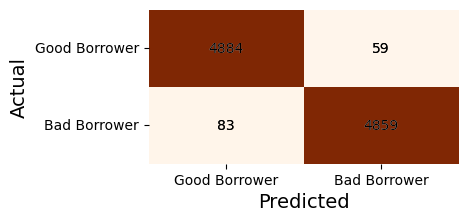

In [59]:
## confusion matrix -- XGBoost


cm_xgb = confusion_matrix(target_test, target_pred_xgb)
labels = ['Good Borrower', 'Bad Borrower']

cm_df_xgb = pd.DataFrame(cm_xgb, index=labels, columns=labels)

## plotting the dataframe for better visualizaiton and interpretation
plt.figure(figsize=(4, 2))
sns.heatmap(cm_df_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

## Had to use below code because labels were being left off
for i in range(cm_df_xgb.shape[0]):
    for j in range(cm_df_xgb.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm_df_xgb.iat[i, j]}',
                 ha='center', va='center', color='black', fontsize=10)

plt.show()

AUC Score: 0.99


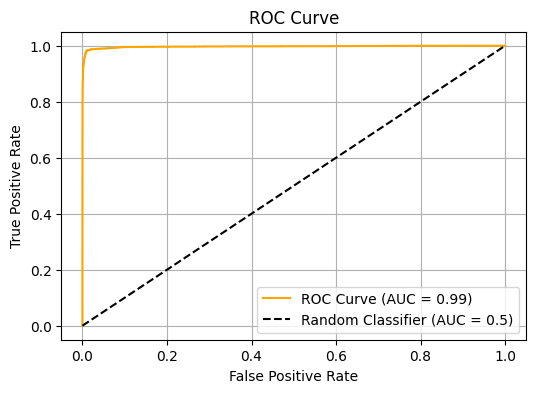

In [60]:
auc_score = roc_auc_score(target_test, target_pred_xgb)
print(f"AUC Score: {auc_score:.2f}")

fpr, tpr, thresholds = roc_curve(target_test, xgb_model.predict_proba(features_test_scaled)[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="orange")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Random Forest Feature Importance

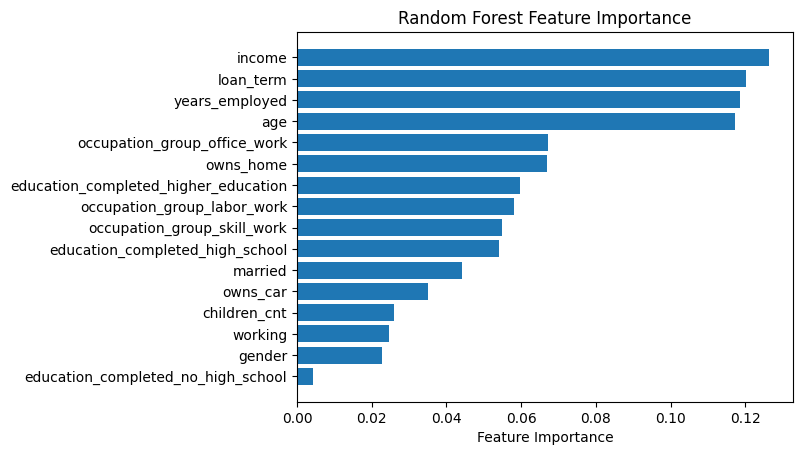

In [61]:
 #Check feature importance for Random Forest
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = features.columns
sorted_indices = importances.argsort()

#Plot feature importance
plt.barh(feature_names[sorted_indices], importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

## Limitations

__Data Scope:__
* The dataset used in this project is limited to specific financial features and historical loan data. It does not include external variables like economic trends, regional differences, or other macroeconomic indicators that may affect loan default probabilities.
  
* The analysis relies on historical data, which may not fully represent future trends or behaviors.

* The source of the data is not well known or documented and may not represent accurate customer behaviors.

__Target Definition:__
* The definition of "good" or "bad" clients is based on the first occurance of a missed payment > 60 days. This might oversimplify the complex factors contributing to loan repayment or default. 
  
* Additional dimensions like overdue duration, frequency of late payments, or other risk factors were not incorporated.

__Imbalance Handling:__
* Techniques like SMOTE and RandomUnderSampler were applied, synthetic sampling might introduce noise or create less realistic patterns in the minority class. This could affect the model's generalizability.


## Future Work

__Data Augmentation:__
* Incorporate external data, such as credit bureau reports, macroeconomic indicators, or demographic information, to enhance model performance and robustness.

* Explore temporal patterns in the data using time-series analysis to understand trends in repayment behavior.

__Model Development:__
* Experiment with additional machine learning models, such as LightGBM, CatBoost, or neural networks, to assess their performance on this task.

* Conduct extensive hyperparameter tuning using techniques like Grid Search or Bayesian Optimization to optimize model performance.

__Advanced Feature Engineering:__
* Develop features based on repayment trends (e.g., changes in overdue rates over time) or customer behavior patterns.

* Explore text-based features (e.g., customer comments or feedback) if available.
  
__Explainability:__
* Investigate alternative explainability tools, such as LIME, to provide more localized interpretations of predictions for individual clients.


## Conclusion

This project aimed to predict whether loan applicants would be classified as "good" or "bad" clients, using historical financial data and engineered features. Our analysis and model results show promise and can be used to aid the creation of PD and LGD models and scorecards for loan applications.

__Model Performance:__
* Among the models tested, Random Forest and XGBoost demonstrated strong performance, with balanced metrics on imbalanced data after using SMOTE for oversampling.

* Logistic Regression provided a baseline but struggled with the data.

* Overall, all models performed well and there were no signs of overfitting as indicated by the cross validation done for each of our models.

__Feature Insights:__
* Features like income per family member and employed-to-age ratio emerged as important predictors, highlighting the value of thoughtful feature engineering.


